In [3]:
from ase.io.cube import read_cube_data
import pandas as pd
import numpy as np
from ase import Atoms
from ase.visualize import view
import math
import matplotlib.pyplot as plt
import os
                      

In [4]:
#calculate freezing distancce of 3000eV Na scattered from InAs at 125º
#the projectile comes out in surface normal direction

def freezingDistance(E,theta):
    #NA=6.02*(10^23)   #Avogadora 
    #m=22.989769/NA/1000 #Na mass in kg
    #E=E*1.60217662*(10^-19) #Energy in Joul
    #v=math.sqrt(2*E/m)=math.sqrt(2*E*1.602/22.99*6.02*10000000)
    v=math.sqrt(8389769*E)*math.cos(theta/180*np.pi)
    d=1/0.86*math.log(2*2.23/(0.86*v/2187691))*0.53
    return round(d,2)


In [5]:
# determine the potential at any XYZ
def potential(X,Y,Z,data,offset):
    #convert XYZ to within boundary first
    
    while  X<0: 
        X+=cellX 
    while  X>cellX: 
        X-=cellX
    while  Y<0: 
        Y+=cellY 
    while  Y>cellY: 
        Y-=cellY
    
    X,Y,Z = int(X/dx),int(Y/dy),int(Z/dz)
    
    
    return round(data[X][Y][Z]- offset,2)  

In [6]:
def fzpotential(row,data,offset):
    #convert XYZ to within boundary first
    X,Y,Z = row['x'],row['y'],row['z']
    zf = freeze_In if row['atom'] == 'In' else freeze_As  
    
    return potential(X,Y,Z+zf,data,offset)

In [7]:
# determine the potential above each atom
def potential_vs_z(row,Zrange,azi,theta,data,offset):
    
    X,Y,Z = row['x'],row['y'],row['z']
    
    cx = math.sin(theta/180*np.pi)*math.cos(azi/180*np.pi)
    cy = math.sin(theta/180*np.pi)*math.sin(azi/180*np.pi)
    cz = math.cos(theta/180*np.pi)
    
    p_vs_z=[]
    
    for delta_z in Zrange: 
        ddx,ddy,ddz = delta_z*cx,delta_z*cy,delta_z*cz
        p_vs_z+=[potential(X+ddx,Y+ddy,Z+ddz,data,offset)]
    return p_vs_z 


In [8]:
# determine the average potential above each atom
def avg_potential_vs_z(row,Zrange,azi,theta,data,offset):
    X,Y,Z = row['x'],row['y'],row['z']
    avg_p_z=[]
    r=1    #radius of the avarage area
    XYpairs=[]
    for delta_x in np.linspace(-r,r,9):
        for delta_y in np.linspace(-r, r, 9):
            if np.abs(delta_x+delta_y*1.j)<=r:
                PX,PY=X+delta_x,Y+delta_y
                XYpairs+=[(PX,PY)]
    
    cx = math.sin(theta/180*np.pi)*math.cos(azi/180*np.pi)
    cy = math.sin(theta/180*np.pi)*math.sin(azi/180*np.pi)
    cz = math.cos(theta/180*np.pi)
    
    for delta_z in Zrange: 
        ddx,ddy,ddz = delta_z*cx,delta_z*cy,delta_z*cz
        
        p_tot = []
        for PX,PY in XYpairs:
            p_tot.append(potential(PX+ddz,PY+ddy,Z+ddz,data,offset))
        
        avg_p_z+=[round(np.mean(p_tot),2)]

    return avg_p_z 



In [9]:
#use RCT model to determine NF scattered from each site
def NF(row,vmax):
    zf = freeze_In if row['atom'] == 'In' else freeze_As  
    
    #calculate s level after shifting 
    dE = 27.2/math.sqrt((27.2*27.2)/(vmax*vmax) + 16*(zf/0.53)**2)
    Es = -5.14+dE
    
    #calculating broadening of the s level
    broad = 27.2*2.23/math.sqrt(math.sqrt(math.exp(4*0.86*zf/0.53)+(2.23/0.04)**4-1))
    
    #guassion integral
    sigma = broad/1.38629
    NF = 0.5+0.5*math.erf((row['fz_potential']-Es)/(1.414*sigma))
    
    return round(NF*100,1) #NF in %

In [10]:
def NF_vs_z(row,vmax):
    zf = freeze_In if row['atom'] == 'In' else freeze_As  
    
    #calculate s level after shifting 
    dE = 27.2/math.sqrt((27.2*27.2)/(vmax*vmax) + 16*(zf/0.53)**2)
    Es = -5.14+dE
    
    #calculating broadening of the s level
    broad = 27.2*2.23/math.sqrt(math.sqrt(math.exp(4*0.86*zf/0.53)+(2.23/0.04)**4-1))*2
    
    #guassion integral
    sigma = broad/1.38629
    NFs=[]
    for Ei in row['p_vs_z']:
        NF = 0.5+0.5*math.erf((Ei-Es)/(1.414*sigma))
        NFs += [round(NF*100,1)]
    
    return NFs #NF in %

In [11]:
def vs_z_plot(Zrange,atomdf,azi,col):
    
    if azi==0:
        for i in visible_0_As:
            plt.plot(Zrange,atomdf.loc[i][col],'-',label='As'+str(i))
        for i in visible_0_In:
            plt.plot(Zrange,atomdf.loc[i][col],'--', label='In'+str(i))
    
    else:
        for i in visible_90_As:
            plt.plot(Zrange,atomdf.loc[i][col],'-',label='As'+str(i))
        for i in visible_90_In:
            plt.plot(Zrange,atomdf.loc[i][col],'--',label='In'+str(i))
    
    plt.axvline(x=freeze_As,color='k', linestyle='-')
    plt.axvline(x=freeze_In,color='k', linestyle='--')
    
    if col=='NF_vs_z':
        plt.axhline(y=expNF[str(azi)]['As'], color='b', linestyle='-')
        plt.axhline(y=expNF[str(azi)]['In'], color='g', linestyle='--')

        plt.axhspan(expNF[str(azi)]['As']-expNF[str(azi)]['As_e'],expNF[str(azi)]['As']+expNF[str(azi)]['As_e'],
                    color='b', linestyle='-', alpha = 0.1)
        plt.axhspan(expNF[str(azi)]['In']-expNF[str(azi)]['In_e'],expNF[str(azi)]['In']+expNF[str(azi)]['In_e'],
                    color='g', linestyle='--', alpha = 0.1)
    
    plt.legend(loc='best')
    #plt.savefig(dataname[:4]+col)

In [12]:
def readdata(dataname,Zrange,fermishift,vmax,azi,theta,plotname):
    print(dataname)

    data,atoms=read_cube_data(dataname)

    offset = data.mean(axis=0).mean(axis=0).max() + fermishift  #potential at infinite far
    print(offset)
    
    atomxyz = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()

    atomdf = pd.concat([pd.DataFrame(atomxyz,columns=['x', 'y', 'z']),
                        pd.DataFrame(symbols,columns=['atom'])],
                       axis=1)
    
    
    
    atomdf['fz_potential'] = atomdf.apply(fzpotential,data=data,offset=offset,axis=1)
    atomdf['NF'] = atomdf.apply(NF,vmax = vmax, axis=1)
    
    atomdf['p_vs_z'] = atomdf.apply(potential_vs_z,Zrange=Zrange,azi=azi,theta=theta,data=data,offset=offset,axis=1)
    #atomdf['p_vs_z_0'] = atomdf.apply(potential_vs_z,Zrange=Zrange,azi=0,thetaaxis=1)
    #atomdf['p_vs_z_90'] = atomdf.apply(potential_vs_z,Zrange=Zrange,azi=90,thetaaxis=1)
    
    atomdf['avg_p_z']=atomdf.apply(avg_potential_vs_z,Zrange=Zrange,azi=azi,theta=theta,data=data,offset=offset,axis=1)
    atomdf['NF_vs_z'] = atomdf.apply(NF_vs_z,vmax = vmax,axis=1)
    
    
    if plotname == 'p_vs_z':
        plt.figure(figsize=(10,10))
        ax=plt.subplot(211)
        vs_z_plot(Zrange,atomdf,0,'p_vs_z')
        ax.set_title(dataname[:4]+'0')

        ax2=plt.subplot(212)
        vs_z_plot(Zrange,atomdf,90,'p_vs_z')
        ax2.set_title(dataname[:4]+'90')
    
    if plotname == 'NF_vs_z':
        plt.figure(figsize=(10,10))
        plt.axis([1, 4, 0, 100])
        ax=plt.subplot(211)
        vs_z_plot(Zrange,atomdf,0,'NF_vs_z')
        ax.set_title(dataname[:4]+'0')

        ax2=plt.subplot(212)
        vs_z_plot(Zrange,atomdf,90,'NF_vs_z')
        ax2.set_title(dataname[:4]+'90')
    #view(atoms)
    

2.94 2.83
zeta_A_potential.cube
5.031288292478354
beta_2_potential.cube
5.053590377164502


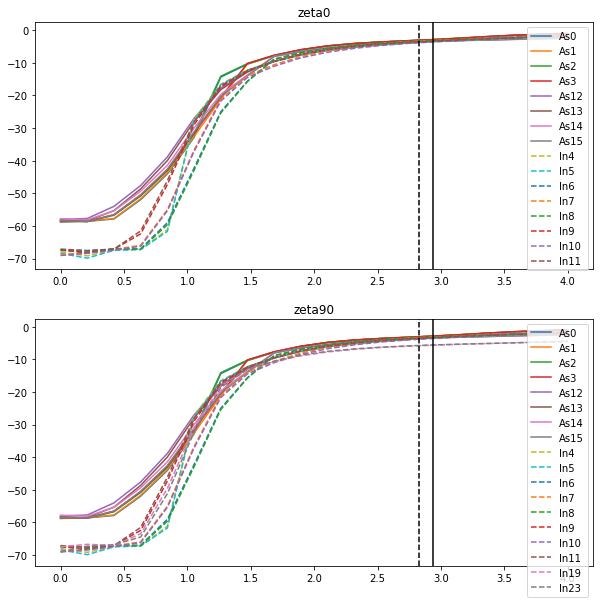

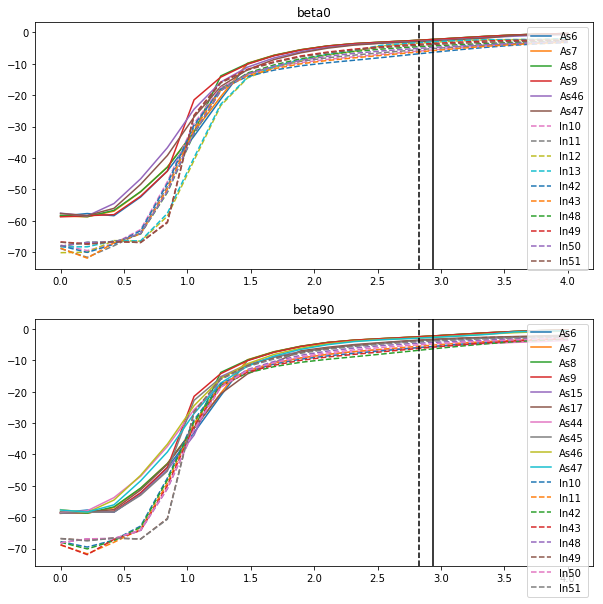

In [15]:
# some constants
vmax = 2.6
fermishift = 0
azi = 0
theta = 0
Zrange = np.linspace(0,4,20) 

freeze_As=freezingDistance(1100,theta)#freezing distance from As
freeze_In=freezingDistance(1582,theta) #freezing distance from In

#freeze_As=1.6 #freezing distance from As
#freeze_In=1.7 #freezing distance from In
print(freeze_As,freeze_In)

dx,dy,dz = 8.54/44,17.08/84,25/124
cellX,cellY,cellZ=8.54, 17.08, 25.

for file in os.listdir():
    if file.endswith(".cube"):
        
        if file=='zeta_A_potential.cube':
            visible_90_As = [0,1,2,3,12,13,14,15]
            visible_90_In = [4,5,6,7,8,9,10,11,19,23]
            visible_0_As = [0,1,2,3,12,13,14,15]
            visible_0_In = [4,5,6,7,8,9,10,11]
            efermi = - 0.2086
            wf = 5.24
            expNF={'0':{'As':57,'In':48,'As_e':9,'In_e':6},'90':{'As':65,'In':40,'As_e':19,'In_e':4}}
        else:
            visible_90_As = [6,7,8,9,15,17,44,45,46,47]
            visible_90_In = [10,11,42,43,48,49,50,51]
            visible_0_As = [6,7,8,9,46,47]
            visible_0_In = [10,11,12,13,42,43,48,49,50,51]
            efermi = - 0.322
            wf = 5.38
            expNF={'0':{'As':67,'In':34,'As_e':23,'In_e':3},'90':{'As':50,'In':41,'As_e':10,'In_e':7}}
    
        readdata(file,Zrange,fermishift,vmax,azi,theta,'p_vs_z')